In [22]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
import math
import numpy as np
import numpy.matlib

class EIRecLinear(nn.Module):

    r"""Recurrent E-I Linear transformation.

    This module implements a linear transformation with recurrent E-I dynamics,
    where part of the units are excitatory and the rest are inhibitory.

    Args:
        hidden_size: int, the number of units in the layer.
        e_prop: float between 0 and 1, the proportion of excitatory units.
        bias: bool, if True, adds a learnable bias to the output.
    """

    __constants__ = ['bias', 'hidden_size', 'e_prop']

    def __init__(self, hidden_size, e_prop, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.e_prop = e_prop
        self.e_size = int(e_prop * hidden_size) # Number of excitatory units
        self.i_size = hidden_size - self.e_size # Number of inhibitory units

        # Weight matrix for the recurrent connections
        self.weight = nn.Parameter(torch.Tensor(hidden_size, hidden_size))

        # Create a mask to define the E-I interactions
        # The mask has ones for E to E/I and negative ones for I to E/I, except the diagonal

        mask_no_diag = np.ones((self.hidden_size,self.hidden_size)) -  np.diag(np.ones((self.hidden_size)))

        E_I_unit_list = np.concatenate((np.ones((self.e_size,1)),-1*np.ones((self.i_size,1)))).T

        mask = mask_no_diag*E_I_unit_list

        self.mask = torch.tensor(mask, dtype=torch.float32)

        # Optionally add a bias term
        if bias:
            self.bias = nn.Parameter(torch.Tensor(hidden_size))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        # Initialize weights and biases
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        # Scale the weights for the excitatory neurons
        self.weight.data[:, :self.e_size] /= (self.e_size/self.i_size)

        # Initialize biases
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def effective_weight(self):
        # Apply the mask you have already created to the weights after applying rectification to get the effective weight
        # This ensures that weights from excitatory neurons are positive,
        # and weights from inhibitory neurons are negative.
        eff_W = F.relu(self.weight)*self.mask
        return eff_W

    def forward(self, input):
        # Apply the linear transformation using the effective weights and biases
        # The weights used are non-negative due to the absolute value in effective_weight.
        return F.linear(input, self.effective_weight(), self.bias)


In [23]:
class EIRNN(nn.Module):
    """E-I RNN.

    Reference:
        Song, H.F., Yang, G.R. and Wang, X.J., 2016.
        Training excitatory-inhibitory recurrent neural networks
        for cognitive tasks: a simple and flexible framework.
        PLoS computational biology, 12(2).

    Args:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons

    Inputs:
        input: (seq_len, batch, input_size)
        hidden: (batch, hidden_size)
        e_prop: float between 0 and 1, proportion of excitatory neurons
    """

    def __init__(self, input_size, hidden_size, dt=None,
                 e_prop=0.8, sigma_rec=0, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.e_size = int(hidden_size * e_prop)
        self.i_size = hidden_size - self.e_size
        self.num_layers = 1
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha
        self.oneminusalpha = 1 - alpha
        # Recurrent noise parameter, scaled by the discretization (sqrt(2*alpha)) and noise level (sigma_rec)
        # This adds stochasticity to the recurrent dynamics, possibly simulating biological neural variability
        self._sigma_rec = np.sqrt(2*alpha) * sigma_rec

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = EIRecLinear(hidden_size, e_prop=0.8)

    def init_hidden(self, input):
        batch_size = input.shape[1]
        return (torch.zeros(batch_size, self.hidden_size).to(input.device),
                torch.zeros(batch_size, self.hidden_size).to(input.device))

    def recurrence(self, input, hidden):
        """Recurrence helper."""
        state, output = hidden
        total_input = self.input2h(input) + self.h2h(output)

        state = state * self.oneminusalpha + total_input * self.alpha
        state += self._sigma_rec * torch.randn_like(state)
        output = torch.relu(state)
        return state, output

    def forward(self, input, hidden=None):
        """Propogate input through the network."""
        if hidden is None:
            hidden = self.init_hidden(input)

        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden[1])
        output = torch.stack(output, dim=0)
        return output, hidden

In [24]:
class Net(nn.Module):
    """Recurrent network model.

    Args:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
        rnn: str, type of RNN, lstm, rnn, ctrnn, or eirnn
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Excitatory-inhibitory RNN
        self.rnn = EIRNN(input_size, hidden_size, **kwargs)
        self.fc = nn.Linear(self.rnn.e_size, output_size)

    def forward(self, x):
        rnn_activity, _ = self.rnn(x)
        rnn_e = rnn_activity[:, :, :self.rnn.e_size]
        out = self.fc(rnn_e)
        return out, rnn_activity

In [25]:
%%capture
# @title Generating dataset from a perceptual decision making task
! git clone https://github.com/neurogym/neurogym.git
%cd neurogym/
! pip install -e .

In [26]:
%%capture
# @title import the task from the neurogym library

import neurogym as ngym

import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

# Environment
task = 'PerceptualDecisionMakingDelayResponse-v0'
timing = {
    'fixation': ('choice', (50, 100, 200, 400)),
    'stimulus': ('choice', (100, 200, 400, 800)),
    'delay': ('choice', (100, 200, 400, 800)),
}
kwargs = {'dt': 20, 'timing': timing}
seq_len = 100

# Make supervised dataset
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=16,
                       seq_len=seq_len)

# A sample environment from dataset
env = dataset.env
# Visualize the environment with 2 sample trials
_ = ngym.utils.plot_env(env, num_trials=2)

# Network input and output size
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

### Train the network on the decision making task

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Net(
  (rnn): EIRNN(
    (input2h): Linear(in_features=3, out_features=128, bias=True)
    (h2h): EIRecLinear()
  )
  (fc): Linear(in_features=102, out_features=3, bias=True)
)
Step 100, Loss 0.5367
Step 200, Loss 0.4368
Step 300, Loss 0.4340
Step 400, Loss 0.4271
Step 500, Loss 0.4259
Step 600, Loss 0.4271
Step 700, Loss 0.4196
Step 800, Loss 0.4012
Step 900, Loss 0.4044
Step 1000, Loss 0.4118
Step 1100, Loss 0.3849
Step 1200, Loss 0.3953
Step 1300, Loss 0.3875
Step 1400, Loss 0.3961
Step 1500, Loss 0.4113
Step 1600, Loss 0.3889
Step 1700, Loss 0.3946
Step 1800, Loss 0.4163
Step 1900, Loss 0.4141
Step 2000, Loss 0.3834
Step 2100, Loss 0.3832
Step 2200, Loss 0.3808
Step 2300, Loss 0.3673
Step 2400, Loss 0.3660
Step 2500, Loss 0.3769
Step 2600, Loss 0.3796
Step 2700, Loss 0.3651
Step 2800, Loss 0.3564
Step 2900, Loss 0.3499
Step 3000, Loss 0.3626
Step 3100, Loss 0.3795
Step 3200, Loss 0.4064
Step 3300, Loss 0.3737
Step 3400, Loss 0.3728
Step 3500, Loss 0.3738
Step 3600, Loss 0.3616
Step

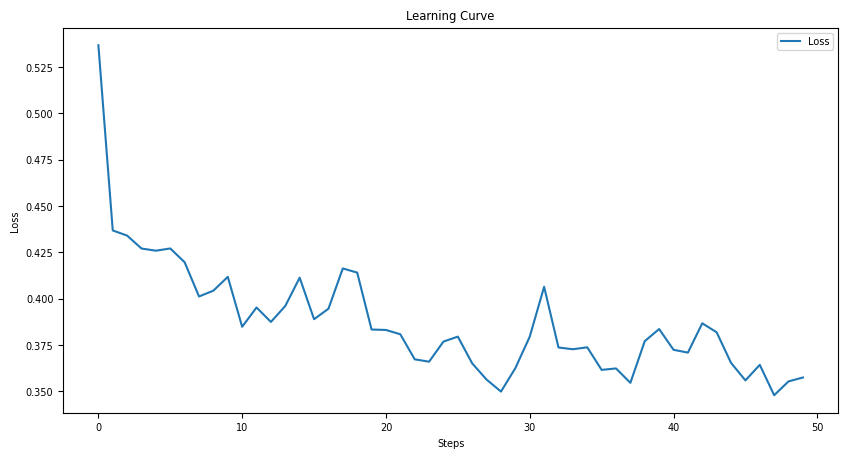

In [27]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

# Assuming Net is defined somewhere and dataset() function is defined
# Assuming input_size and output_size are also defined

# Instantiate the network
hidden_size = 128
net = Net(input_size=input_size, hidden_size=hidden_size,
          output_size=output_size, dt=env.dt, sigma_rec=0.15)
print(net)

# Use Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

loss_values = []  # List to store loss values
running_loss = 0.0
print_step = 100
for i in range(5000):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # Zero the gradient buffers
    optimizer.zero_grad()

    # Forward pass
    output, activity = net(inputs)
    output = output.view(-1, output_size)

    # Compute loss
    loss = criterion(output, labels)

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    # Update running loss
    running_loss += loss.item()
    if i % print_step == (print_step - 1):
        average_loss = running_loss / print_step
        print('Step {}, Loss {:0.4f}'.format(i+1, average_loss))
        loss_values.append(average_loss)  # Append average loss here
        running_loss = 0.0

# Plotting the learning curve
plt.figure(figsize=(10,5))
plt.title("Learning Curve")
plt.plot(loss_values, label='Loss')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()


Net(
  (rnn): EIRNN(
    (input2h): Linear(in_features=3, out_features=128, bias=True)
    (h2h): EIRecLinear()
  )
  (fc): Linear(in_features=102, out_features=3, bias=True)
)
Training network...
Step 100, Loss 0.5791, Time 5.9s
Step 200, Loss 0.4742, Time 12.0s
Step 300, Loss 0.4444, Time 18.5s
Step 400, Loss 0.4350, Time 24.0s
Step 500, Loss 0.4299, Time 30.8s
Step 600, Loss 0.4267, Time 36.3s
Step 700, Loss 0.4258, Time 43.1s
Step 800, Loss 0.4188, Time 48.7s
Step 900, Loss 0.4158, Time 55.8s
Step 1000, Loss 0.4178, Time 61.5s
Step 1100, Loss 0.4253, Time 68.0s
Step 1200, Loss 0.4188, Time 74.0s
Step 1300, Loss 0.4061, Time 79.9s
Step 1400, Loss 0.4065, Time 86.5s
Step 1500, Loss 0.3944, Time 92.2s
Step 1600, Loss 0.3999, Time 98.9s
Step 1700, Loss 0.3922, Time 104.6s
Step 1800, Loss 0.3955, Time 111.7s
Step 1900, Loss 0.3971, Time 117.2s
Step 2000, Loss 0.4043, Time 124.2s
Step 2100, Loss 0.3938, Time 129.8s
Step 2200, Loss 0.3850, Time 136.0s
Step 2300, Loss 0.3853, Time 142.5s
S

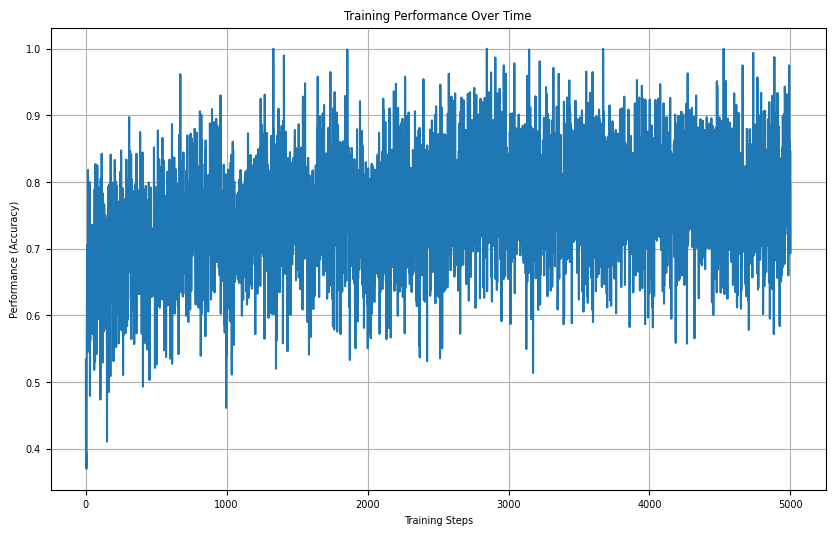

In [28]:
import torch
import torch.optim as optim
import torch.nn as nn
import time
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)
import matplotlib.pyplot as plt

# Assuming the RNNNet class and other parts are defined as before.

def train_model(net, dataset):
    """Simple helper function to train the model.

    Args:
        net: a pytorch nn.Module module
        dataset: a dataset object that when called produce a (input, target output) pair

    Returns:
        net: network object after training
        performance: List of performance values at each step
    """
    # Use Adam optimizer
    optimizer = optim.Adam(net.parameters(), lr=0.005)
    criterion = nn.CrossEntropyLoss()

    running_loss = 0
    performance = []  # To store performance at each step (accuracy)
    start_time = time.time()

    # Loop over training batches
    print('Training network...')
    for i in range(5000):
        # Generate input and target, convert to pytorch tensor
        inputs, labels = dataset()
        inputs = torch.from_numpy(inputs).type(torch.float)
        labels = torch.from_numpy(labels.flatten()).type(torch.long)

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        output, _ = net(inputs)

        # Reshape to (SeqLen x Batch, OutputSize)
        output = output.view(-1, output_size)

        # Compute loss
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()  # Updates the weights

        # Compute running loss every 100 steps
        running_loss += loss.item()
        if i % 100 == 99:
            running_loss /= 100
            print(f'Step {i+1}, Loss {running_loss:.4f}, Time {time.time() - start_time:.1f}s')
            running_loss = 0

        # Compute accuracy for current batch (every step)
        with torch.no_grad():
            # Get predicted labels
            _, predicted = torch.max(output, 1)
            correct = (predicted == labels).sum().item()
            accuracy = correct / labels.size(0)

        # Store accuracy at this step
        performance.append(accuracy)

    return net, performance

# Instantiate the network
hidden_size = 128
net = Net(input_size=input_size, hidden_size=hidden_size, output_size=output_size, dt=env.dt)
print(net)

# Train the model and track performance
net, performance = train_model(net, dataset)

# Plot performance
plt.figure(figsize=(10, 6))
plt.plot(range(1, 5001), performance)  # X-axis: steps, Y-axis: performance (accuracy)
plt.xlabel('Training Steps')
plt.ylabel('Performance (Accuracy)')
plt.title('Training Performance Over Time')
plt.grid(True)
plt.show()


In [32]:
# Reset environment
env = dataset.env
env.reset(no_step=True)

# Initialize variables for logging
perf = 0
activity_dict = {}  # recording activity
trial_infos = {}  # recording trial information


num_trial = 200
for i in range(num_trial):
    # Neurogym boiler plate
    # Sample a new trial
    trial_info = env.new_trial()
    # Observation and groud-truth of this trial
    ob, gt = env.ob, env.gt
    # Convert to numpy, add batch dimension to input
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)

    # Run the network for one trial
    # inputs (SeqLen, Batch, InputSize)
    # action_pred (SeqLen, Batch, OutputSize)
    action_pred, rnn_activity = net(inputs)

    # Compute performance
    # First convert back to numpy
    action_pred = action_pred.detach().numpy()[:, 0, :]
    # Read out final choice at last time step
    choice = np.argmax(action_pred[-1, :])
    # Compare to ground truth
    correct = choice == gt[-1]


    # Record activity, trial information, choice, correctness
    rnn_activity = rnn_activity[:, 0, :].detach().numpy()
    activity_dict[i] = rnn_activity
    trial_infos[i] = trial_info  # trial_info is a dictionary
    trial_infos[i].update({'correct': correct})


# Print information for sample trials
for i in range(10):
    print('Trial ', i, trial_infos[i])

print('Average performance', np.mean([val['correct'] for val in trial_infos.values()]))



Trial  0 {'ground_truth': 1, 'coh': 0.0, 'sigma': 0.22360679774997896, 'correct': True}
Trial  1 {'ground_truth': 2, 'coh': 6.4, 'sigma': 0.22360679774997896, 'correct': True}
Trial  2 {'ground_truth': 2, 'coh': 12.8, 'sigma': 0.22360679774997896, 'correct': True}
Trial  3 {'ground_truth': 2, 'coh': 6.4, 'sigma': 0.22360679774997896, 'correct': False}
Trial  4 {'ground_truth': 1, 'coh': 12.8, 'sigma': 0.22360679774997896, 'correct': True}
Trial  5 {'ground_truth': 1, 'coh': 25.6, 'sigma': 0.22360679774997896, 'correct': True}
Trial  6 {'ground_truth': 2, 'coh': 6.4, 'sigma': 0.22360679774997896, 'correct': True}
Trial  7 {'ground_truth': 2, 'coh': 12.8, 'sigma': 0.22360679774997896, 'correct': True}
Trial  8 {'ground_truth': 1, 'coh': 0.0, 'sigma': 0.22360679774997896, 'correct': False}
Trial  9 {'ground_truth': 1, 'coh': 25.6, 'sigma': 0.22360679774997896, 'correct': True}
Average performance 0.83


Text(0, 0.5, 'Activity')

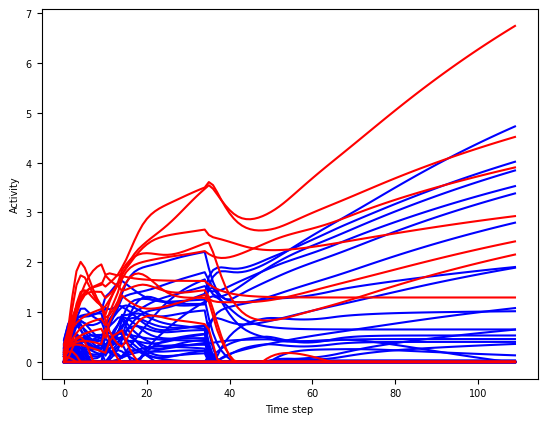

In [30]:
# @title Plot neural activity from sample trials
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)


import matplotlib.pyplot as plt

e_size = net.rnn.e_size
trial = 2

plt.figure()
_ = plt.plot(activity_dict[trial][:, :e_size], color='blue', label='Excitatory')
_ = plt.plot(activity_dict[trial][:, e_size:], color='red', label='Inhibitory')
plt.xlabel('Time step')
plt.ylabel('Activity')

Shape of the neural activity: (Time points, Neurons):  (23818, 128)
Shape of the projected activity: (Time points, PCs):  (23818, 2)


Text(0, 0.5, 'PC 2')

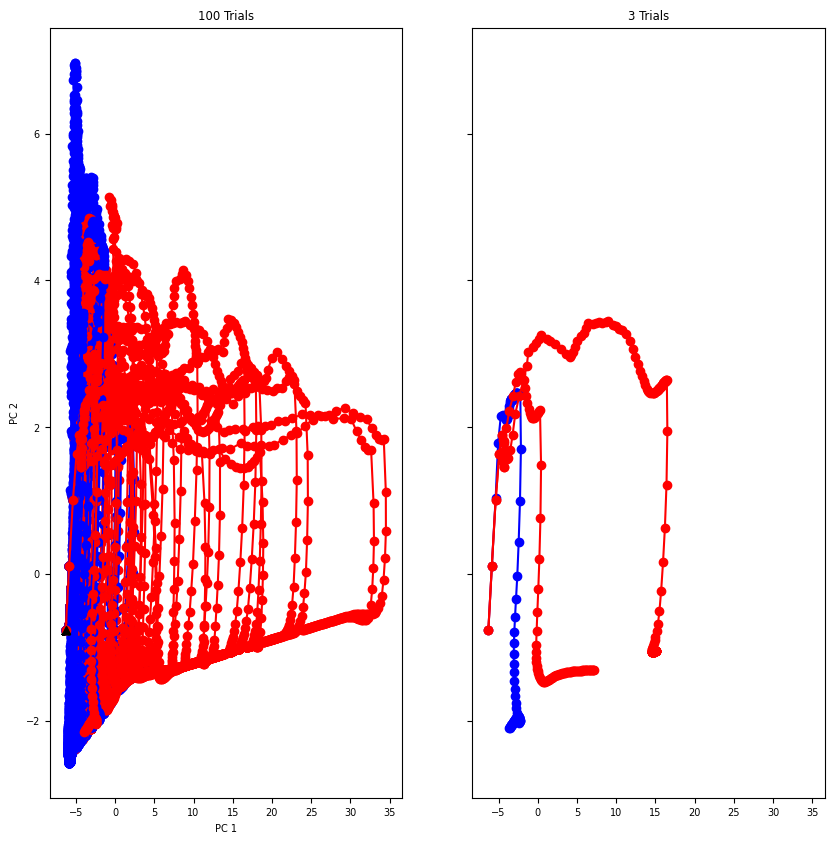

In [31]:
# Apply PCA, boilerplate sklearn
from sklearn.decomposition import PCA

# Concatenate activity for PCA
activity = np.concatenate(list(activity_dict[i] for i in range(num_trial)), axis=0)
print('Shape of the neural activity: (Time points, Neurons): ', activity.shape)

pca = PCA(n_components=2)
pca.fit(activity)  # activity (Time points, Neurons)
activity_pc = pca.transform(activity)  # transform to low-dimension
print('Shape of the projected activity: (Time points, PCs): ', activity_pc.shape)

# Project each trial and visualize activity

import matplotlib.pyplot as plt


# Plot all trials in ax1, plot fewer trials in ax2
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(10, 10))

for i in range(100):
    # Transform and plot each trial
    activity_pc = pca.transform(activity_dict[i])  # (Time points, PCs)

    trial = trial_infos[i]
    color = 'red' if trial['ground_truth'] == 1 else 'blue'

    _ = ax1.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-', color=color)
    if i < 3:
        _ = ax2.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-', color=color)

    # Plot the beginning of a trial with a special symbol
    _ = ax1.plot(activity_pc[0, 0], activity_pc[0, 1], '^', color='black')

ax1.set_title('{:d} Trials'.format(100))
ax2.set_title('{:d} Trials'.format(3))
ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
